In [5]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass


class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet
        self.max_fitness = len(target)

    def init_population(self, pop_size):
        # raise NotImplementedError()
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
        score = 0
        for i in range(len(sample)):
            if sample[i] is self.target[i]: score += 1
        return score

    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population

        hint: make a new individual with 

        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)

        """
        def select(r, population, fitness):
            """
            TODO: select *r* samples from *population*
            the simplest choice is to sample from *population* with each individual weighted by its fitness
            """
            return_list = []

            population_fitness = []
            for individual in population:
                population_fitness.append(fitness(individual))

            threshold = 0
            threshold_list = []
            fit_sum = sum(population_fitness)
            for i in population_fitness:
                threshold_list.append(threshold)
                threshold += i / fit_sum
            threshold_list.append(1)
            
            # while len(return_list) < r:
            #     temp = random.randrange(0, 10) / 10
            #     # print(temp)
            #     for i in range(len(population)):
            #         if temp >= threshold_list[i] and temp <= threshold_list[i + 1]:
            #             if population[i] in return_list:
            #                 return_list.remove(population[i])
            #             return_list.append(population[i])
            #             break
            
            for _ in range(r):
                temp = random.randrange(0, 10) / 10
                # print(temp)
                for i in range(len(population)):
                    if temp >= threshold_list[i] and temp <= threshold_list[i + 1]:
                        return_list.append(population[i])
                        break
            return return_list

        def recombine(x, y):
            """
            TODO: combine two parents to produce an offspring
            """
            cut_off = random.randrange(0, len(self.target))
            return x[:cut_off] + y[cut_off:]
            
        def mutate(x, gene_pool, pmut):
            """
            apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
            """
            if random.uniform(0, 1) >= pmut:
                return x

            n = len(x)
            g = len(gene_pool)
            c = random.randrange(0, n)
            r = random.randrange(0, g)

            new_gene = gene_pool[r]
            return x[:c] + new_gene + x[c + 1:]

        return_list = []
        for i in range(len(population)):
            return_list.append(mutate(\
                        recombine(*select(2, population, self.fitness)), \
                        self.alphabet, mutation_rate))
        return return_list
        

    def replacement(self, old, new, fitness):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        # cut_off = random.randrange(0, len(target))
        # cut_off = int(0.2 * len(target))
        # new = old[:cut_off] + new[cut_off:]
        # new = new[cut_off:]
        # while len(new) < len(self.target):
        #     new_individual = "".join(random.choices(gene_pool, k = len(self.target)))
        #     new.append(new_individual)

        All = old + new
        All = sorted(All, key=lambda t: -fitness(t))
        return All[:len(old)]

def genetic_algorithm(
    problem: GAProblem,
    ngen, n_init_size, mutation_rate,
    log_intervel=100
):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen = problem.reproduce(population, mutation_rate)
        population = problem.replacement(population, next_gen, problem.fitness)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best):
                best = current_best
            print(
                f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")
            history.append((gen, list(map(problem.fitness, population))))

    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

def genetic_algorithm_to_goal(
    problem: GAProblem,
    goal, n_init_size, mutation_rate,
    log_intervel=100
):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    gen = 0
    while problem.fitness(best) < goal:
        next_gen = problem.reproduce(population, mutation_rate)
        population = problem.replacement(population, next_gen, problem.fitness)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best):
                best = current_best
            print(
                f"Generation: {gen}, \tBest: {best},\tFitness={problem.fitness(best)}")
            history.append((gen, list(map(problem.fitness, population))))
        gen += 1

    history.append((gen-1, list(map(problem.fitness, population))))
    return best, history

In [7]:
# now set up the parameters
ngen = 2400
max_population = 60
mutation_rate = 0.2

sid = 12012710  # TODO:  replace this with your own sid
target = f"Genetic Algorithm by {sid}"
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
alphabet = u_case + l_case + [' '] + [str(a) for a in range(0, 10)] 
# TODO: fix this: what is the search space now?

problem = PhraseGeneration(target, alphabet)
goal = len(target)
# and run it
# solution, history = genetic_algorithm(
#     problem, ngen, max_population, mutation_rate)
solution, history = genetic_algorithm_to_goal(
    problem, goal, max_population, mutation_rate)
solution


Generation: 0, 	Best: GA3VI0BWSjp1W2L5Ylp7 lXPf821n,	Fitness=3
Generation: 100, 	Best: GeeetycRAf4HYitjn b7 12X1221n,	Fitness=16
Generation: 200, 	Best: GenetycRAl4HYithm b7 12X12210,	Fitness=21
Generation: 300, 	Best: Genetic Al4Hrithm by 12012710,	Fitness=27
Generation: 400, 	Best: Genetic Algorithm by 12012710,	Fitness=29


'Genetic Algorithm by 12012710'

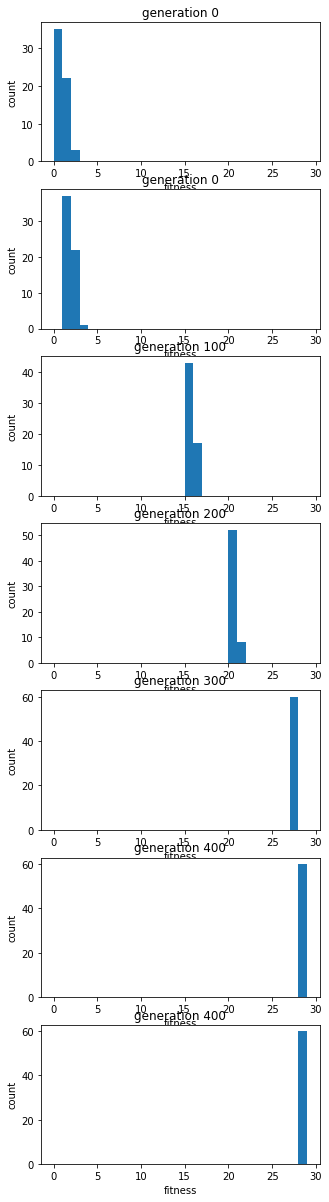

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [8]:
# visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness + 1)
plot_evolution(history, bins)
bins
